## Build CART model using Python

### 1) Import required Libraries

In [1]:
import pandas                   as      pd
import numpy                    as      np
import sklearn.datasets         as      datasets
import matplotlib.pyplot        as      plt

from   sklearn                  import  tree
from   sklearn.tree             import  DecisionTreeClassifier
from   sklearn.tree             import _tree

from   sklearn                  import  metrics 
from   sklearn.metrics          import  classification_report
from   sklearn.metrics          import  confusion_matrix
from   sklearn.metrics          import  roc_curve, auc
from   sklearn.model_selection  import  KFold 
from   six                      import  StringIO
import seaborn                  as      sns
import matplotlib.pyplot        as      plt

from   sklearn.model_selection  import  train_test_split
from   sklearn.model_selection  import  cross_val_score, KFold

import pydotplus
import pydot

%matplotlib inline

In [2]:
def measures_cm(act, pred):
   
    c_matrix = pd.crosstab(act,pred, rownames=['Actual'], colnames=['Predicted'])

    sns.heatmap(c_matrix, annot = True, fmt = '.6g')
    plt.show()
    target_names = [ 'Healthy', 'NPA']
    print(classification_report(act, pred, target_names = target_names))

In [3]:
def draw_roc( actual, probs ):

    import pandas            as   pd
    import numpy             as   np
    import seaborn           as   sns
    import matplotlib.pyplot as   plt
    import sklearn.metrics   as   metrics
    import seaborn           as   sns
    
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
    drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 4))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    plt.show()
    return fpr, tpr, thresholds

In [4]:
def decision_tree_no_pruning(model, X, y, flist, file_name):
    from sklearn.tree            import export_graphviz
    from   six                   import StringIO
    from IPython.core.pylabtools import figsize
    from IPython.display         import Image
    figsize(12.5, 6)
    import pydot

    #dot_data = StringIO()  
    file_name_dot = file_name + '.dot'
    file_name_png = file_name + '.png'
    
    export_graphviz(model, out_file = file_name_dot, feature_names = flist,\
                    class_names = ['Healthy','NPA'],
                    filled = True, rounded = True)
    (graph,) = pydot.graph_from_dot_file(file_name_dot)
    graph.write_png(file_name_png)
    return Image(file_name_png)

In [5]:
def decision_tree_with_pruning(clf, X, y, flist, file_name):
    from sklearn.tree            import export_graphviz
    from   six                   import StringIO
    from IPython.core.pylabtools import figsize
    from IPython.display         import Image
    figsize(12.5, 6)
    import pydot
    #dot_data = StringIO()  
    file_name_dot = file_name + '.dot'
    file_name_png = file_name + '.png'
    
    export_graphviz(clf, out_file = file_name_dot, feature_names = flist,
                    class_names = ['Healthy','NPA'],
                    filled = True, rounded = True)
    (graph,) = pydot.graph_from_dot_file(file_name_dot)
    graph.write_png(file_name_png)
    return Image(file_name_png)

In [6]:
'''
This function returns a set of rules defined in the Decision Tree which is easy to understand
'''
def tree_to_rules(tree, feature_names, class_names):

    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value

    def recurse(left, right, threshold, features, node, depth=0):

        indent = "  " * depth

        if (threshold[node] != -2):

            print(indent,"if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")

            if left[node] != -1:

                recurse (left, right, threshold, features, left[node], depth+1)
                print(indent,"} else {")

                if right[node] != -1:
                    recurse (left, right, threshold, features, right[node], depth+1)

                print(indent,"}")

        else:
            if value[node][0,0] > value[node][0,1]:
              classified = class_names[0]
            else:
              classified = class_names[1]
            print(indent,"Class = " + classified)
    recurse(left, right, threshold, features, 0)

In [7]:
'''
This function calculates the Youdens J score which gives the optimum cut-off
point given the fpr, tpr and thresholds
'''
def get_youdens_j_cutoff(fpr,tpr,thresholds):
    j_scores = tpr-fpr
    j_ordered = sorted(zip(j_scores,thresholds))
    return j_ordered[-1][1]

In [8]:
import   os
folder =  r'D:\DrPKV\20220626\Data'
os.chdir(folder)
print(os.getcwd())

D:\DrPKV\20220626\Data


In [9]:
file1          =   'Predicted_Values_train_data_2022_06_25_08_58_16.csv'
file           =   'Important_9_columns_Data.csv'

In [10]:
df              =    pd.read_csv(file)
df['Target']    =    df['Target'].replace(to_replace = 0, value = 2)
df['Target']    =    df['Target'].replace(to_replace = 1, value = 0)
df['Target']    =    df['Target'].replace(to_replace = 2, value = 1)

print('Train data shape {}'.format(df.shape))

Train data shape (9000, 10)


In [11]:
feature_names =  df.columns

In [12]:
feature_names = feature_names.drop(['Target'])
print(feature_names)

Index(['Cash_ratio', 'Interest_coverage', 'Inventory_turnover',
       'Operating Cash Flow/Total Debt', 'Operating Cash Flow/Total Sales',
       'Shareholderquity_code', 'Total shareholders' funds',
       'YOY EBIT Growth Rate', 'debt_equity'],
      dtype='object')


In [13]:
df_train       =    pd.read_csv(file1)
print('Train data shape {}'.format(df_train.shape))

Train data shape (6300, 9)


In [14]:
df_train.columns

Index(['Train_y_true', 'LR_Train_y_pred', 'CART_Train_y_pred',
       'RF_Train_y_pred', 'SVC_Train_y_pred', 'LDA_Train_y_pred',
       'KNN_Train_y_pred', 'XGBoost_Train_y_pred', 'Consensus-3 models'],
      dtype='object')

In [15]:
required_cols   =   ['Train_y_true',  'CART_Train_y_pred']
df_cart         =   df_train[required_cols]
df_cart.columns                     

Index(['Train_y_true', 'CART_Train_y_pred'], dtype='object')

In [16]:
class_names   =  ['Healthy','NPA']

In [17]:
feature_names

Index(['Cash_ratio', 'Interest_coverage', 'Inventory_turnover',
       'Operating Cash Flow/Total Debt', 'Operating Cash Flow/Total Sales',
       'Shareholderquity_code', 'Total shareholders' funds',
       'YOY EBIT Growth Rate', 'debt_equity'],
      dtype='object')

In [18]:
X              =  df.loc[:,feature_names] 
y              =  df.loc[:,'Target']
label_names    =  y.unique()

In [19]:
seed      = 1
test_size = 0.30

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = seed, stratify = y) 

In [20]:
clf    = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf    = clf.fit(X_train,y_train)

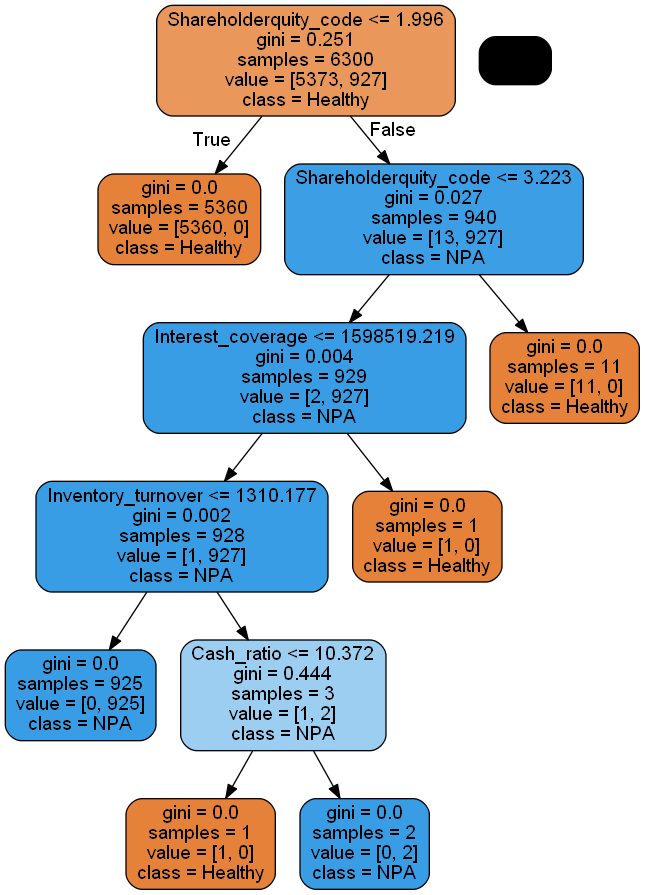

In [21]:
decision_tree_no_pruning(clf, X_train, y_train, feature_names, 'Target')

In [22]:
tree_to_rules(clf, list(X_train.loc[:,feature_names]), class_names)

 if ( Shareholderquity_code <= 1.995553195476532 ) {
   Class = Healthy
 } else {
   if ( Shareholderquity_code <= 3.2228864431381226 ) {
     if ( Interest_coverage <= 1598519.21875 ) {
       if ( Inventory_turnover <= 1310.1774291992188 ) {
         Class = NPA
       } else {
         if ( Cash_ratio <= 10.371807336807251 ) {
           Class = Healthy
         } else {
           Class = NPA
         }
       }
     } else {
       Class = Healthy
     }
   } else {
     Class = Healthy
   }
 }


In [23]:
clf1    =   DecisionTreeClassifier(criterion="entropy", max_depth = 4, min_impurity_decrease = 0)
clf1.fit(X_train, y_train)
#Predict the response for train dataset
predicted_train = clf1.predict(X_train)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_train, predicted_train))

Accuracy: 0.9998412698412699


In [24]:
measures_train     = classification_report(y_train, predicted_train) 
print("\nTraining data")
print(measures_train) 


Training data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5373
           1       1.00      1.00      1.00       927

    accuracy                           1.00      6300
   macro avg       1.00      1.00      1.00      6300
weighted avg       1.00      1.00      1.00      6300



<function matplotlib.pyplot.show(close=None, block=None)>

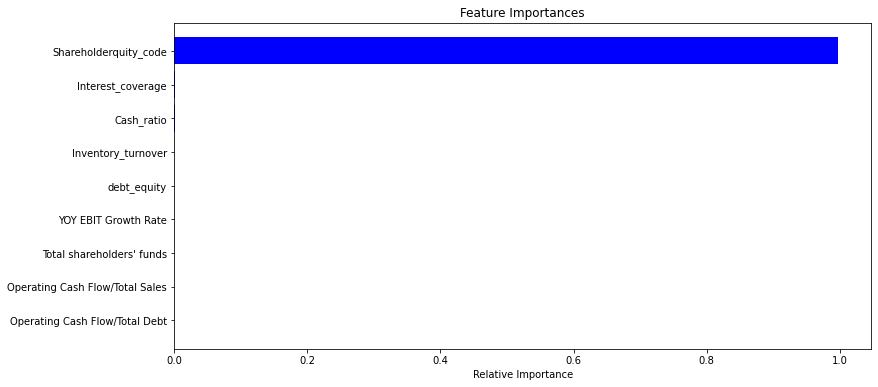

In [25]:
importances = clf.feature_importances_
indices     = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show